Богомолов Владислав

Практическая работа 6 и лабораторная работа 4

Выполним импорт необходимых библиотек

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms,datasets

Зададим нормализующие преобразования, загрузим набор данных (MNIST), разобьем данные на подвыборки

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
transforms.Normalize((0.0,), (1.0,))])
dataset = datasets.MNIST(root = './data', train=True, transform = transform, download=True)
train_set, val_set = torch.utils.data.random_split(dataset, [50000, 10000])
test_set = datasets.MNIST(root = './data', train=False, transform = transform, download=True)
train_loader = torch.utils.data.DataLoader(train_set,batch_size=1,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set,batch_size=1,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=1,shuffle=True)
print("Training data:",len(train_loader),"Validation data:",len(val_loader),"Test data:",len(test_loader))

100%|██████████| 9912422/9912422 [00:00<00:00, 91731430.07it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 42134154.37it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 28234812.31it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6942612.52it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Training data: 50000 Validation data: 10000 Test data: 10000


Настроим использование графического ускорителя

In [ ]:
use_cuda=True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

Создание атак на модель НС

Создадим класс НС на основе фреймворка torch

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    output = F.log_softmax(x, dim=1)
    return output

Проверим работоспособность созданного класса НС

In [ ]:
model = Net().to(device)

Создадим оптимизатор, функцию потерь и трейнер сети

In [ ]:
optimizer = optim.Adam(model.parameters(),lr=0.0001, betas=(0.9, 0.999))
criterion = nn.NLLLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

Определим функцию обучения сети

In [ ]:
def fit(model,device,train_loader,val_loader,epochs):
  data_loader = {'train':train_loader,'val':val_loader}
  print("Fitting the model...")
  train_loss,val_loss=[],[]
  for epoch in range(epochs):
    loss_per_epoch,val_loss_per_epoch=0,0
    for phase in ('train','val'):
      for i,data in enumerate(data_loader[phase]):
        input,label = data[0].to(device),data[1].to(device)
        output = model(input)
        #calculating loss on the output
        loss = criterion(output,label)
        if phase == 'train':
          optimizer.zero_grad()
          #grad calc w.r.t Loss func
          loss.backward()
          #update weights
          optimizer.step()
          loss_per_epoch+=loss.item()
        else:
          val_loss_per_epoch+=loss.item()
    scheduler.step(val_loss_per_epoch/len(val_loader))
    print("Epoch: {} Loss: {} Val_Loss: {}".format(epoch+1,loss_per_epoch/len(train_loader),val_loss_per_epoch/len(val_loader)))
    train_loss.append(loss_per_epoch/len(train_loader))
    val_loss.append(val_loss_per_epoch/len(val_loader))
  return train_loss,val_loss

Обучим модель

In [ ]:
loss, val_loss = fit(model, device, train_loader, val_loader, 10)

Fitting the model...


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 1 Loss: 0.27614872264726387 Val_Loss: 0.12849006702370833
Epoch: 2 Loss: 0.10447770800447254 Val_Loss: 0.08868579311506058
Epoch: 3 Loss: 0.08025635722745197 Val_Loss: 0.08554303462521227
Epoch: 4 Loss: 0.06944339085514234 Val_Loss: 0.08266714049761031
Epoch: 5 Loss: 0.06357613622389108 Val_Loss: 0.07591351316007636
Epoch: 6 Loss: 0.05872933254938032 Val_Loss: 0.07014649663726197
Epoch: 7 Loss: 0.054628231183309645 Val_Loss: 0.07108707125685282
Epoch: 8 Loss: 0.05340241115130823 Val_Loss: 0.06706944807442417
Epoch: 9 Loss: 0.05099399867184642 Val_Loss: 0.07234527880548151
Epoch: 10 Loss: 0.049390421111892346 Val_Loss: 0.0661731527771432


Построим графикипотерь при обучении и валидации в зависимости от эпохи

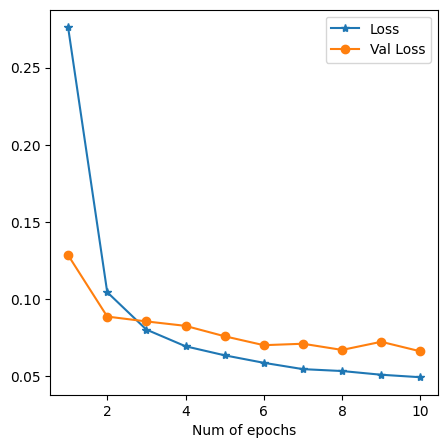

In [ ]:
fig = plt.figure(figsize=(5,5))
plt.plot(np.arange(1,11), loss, "*-",label="Loss")
plt.plot(np.arange(1,11), val_loss,"o-",label="Val Loss")
plt.xlabel("Num of epochs")
plt.legend()
plt.show()

Создадим функции атак FGSM,I-FGSM,MI-FGSM

In [ ]:
def fgsm_attack(input,epsilon,data_grad):
  pert_out = input + epsilon*data_grad.sign()
  pert_out = torch.clamp(pert_out, 0, 1)
  return pert_out

def ifgsm_attack(input,epsilon,data_grad):
  pert_out = input + epsilon*data_grad.sign()
  pert_out = torch.clamp(pert_out, 0, 1)
  return pert_out

def mifgsm_attack(input,epsilon,data_grad):
  iter=10
  decay_factor=1.0
  pert_out = input
  alpha = epsilon/iter
  g=0
  for i in range(iter-1):
    g = decay_factor*g + data_grad/torch.norm(data_grad,p=1)
    pert_out = pert_out + alpha*torch.sign(g)
    pert_out = torch.clamp(pert_out, 0, 1)
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  return pert_out

Создадим функцию проверки

In [ ]:
def test(model,device,test_loader,epsilon,attack):
  correct = 0
  adv_examples = []
  for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    data.requires_grad = True
    output = model(data)
    init_pred = output.max(1, keepdim=True)[1]
    if init_pred.item() != target.item():
      continue
    loss = F.nll_loss(output, target)
    model.zero_grad()
    loss.backward()
    data_grad = data.grad.data
    if attack == "fgsm":
      perturbed_data = fgsm_attack(data,epsilon,data_grad)
    elif attack == "ifgsm":
      perturbed_data = ifgsm_attack(data,epsilon,data_grad)
    elif attack == "mifgsm":
      perturbed_data = mifgsm_attack(data,epsilon,data_grad)
    output = model(perturbed_data)
    final_pred = output.max(1, keepdim=True)[1]
    if final_pred.item() == target.item():
      correct += 1
    if (epsilon == 0) and (len(adv_examples) < 5):
      adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
      adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
    else:
      if len(adv_examples) < 5:
        adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
        adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
  final_acc = correct/float(len(test_loader))
  print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))
  return final_acc, adv_examples

Построим граики успешности атак (Accuracy/эпсилон) и примеры выполненных атак в зависимости от степени возмущения epsilon

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epsilon: 0	Test Accuracy = 9730 / 10000 = 0.973
Epsilon: 0.007	Test Accuracy = 9718 / 10000 = 0.9718
Epsilon: 0.01	Test Accuracy = 9709 / 10000 = 0.9709
Epsilon: 0.02	Test Accuracy = 9634 / 10000 = 0.9634
Epsilon: 0.03	Test Accuracy = 9575 / 10000 = 0.9575
Epsilon: 0.05	Test Accuracy = 9328 / 10000 = 0.9328
Epsilon: 0.1	Test Accuracy = 8348 / 10000 = 0.8348
Epsilon: 0.2	Test Accuracy = 5283 / 10000 = 0.5283
Epsilon: 0.3	Test Accuracy = 3160 / 10000 = 0.316


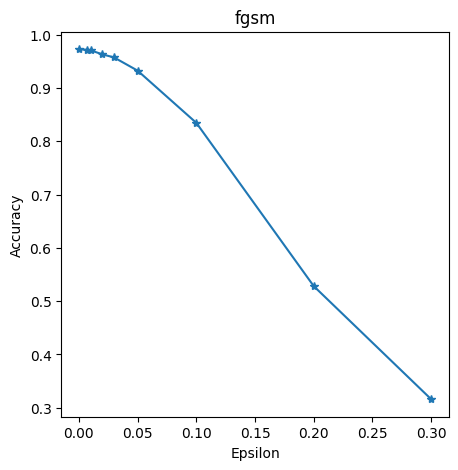

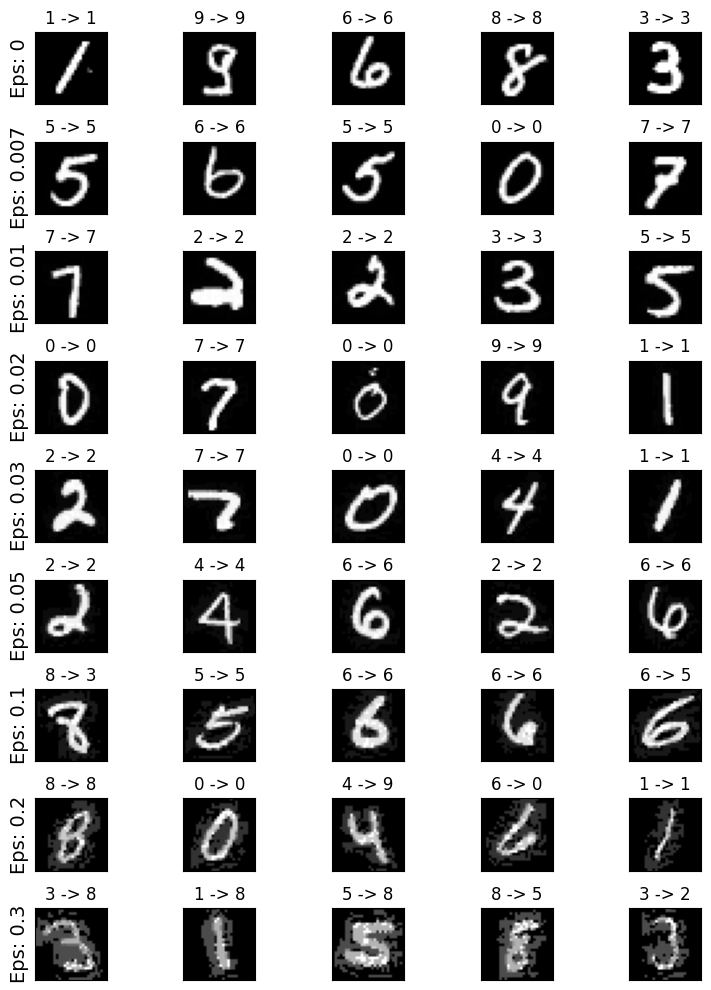

Epsilon: 0	Test Accuracy = 9760 / 10000 = 0.976
Epsilon: 0.007	Test Accuracy = 9712 / 10000 = 0.9712
Epsilon: 0.01	Test Accuracy = 9687 / 10000 = 0.9687
Epsilon: 0.02	Test Accuracy = 9650 / 10000 = 0.965
Epsilon: 0.03	Test Accuracy = 9571 / 10000 = 0.9571
Epsilon: 0.05	Test Accuracy = 9337 / 10000 = 0.9337
Epsilon: 0.1	Test Accuracy = 8375 / 10000 = 0.8375
Epsilon: 0.2	Test Accuracy = 5252 / 10000 = 0.5252
Epsilon: 0.3	Test Accuracy = 3166 / 10000 = 0.3166


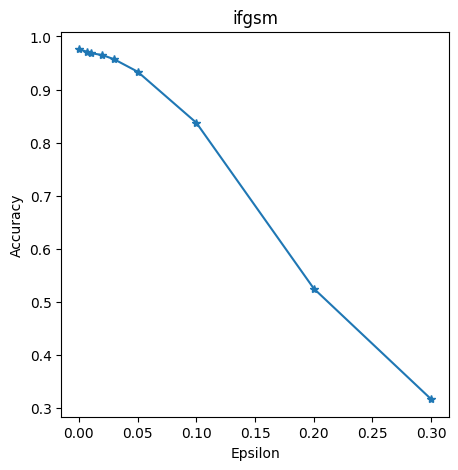

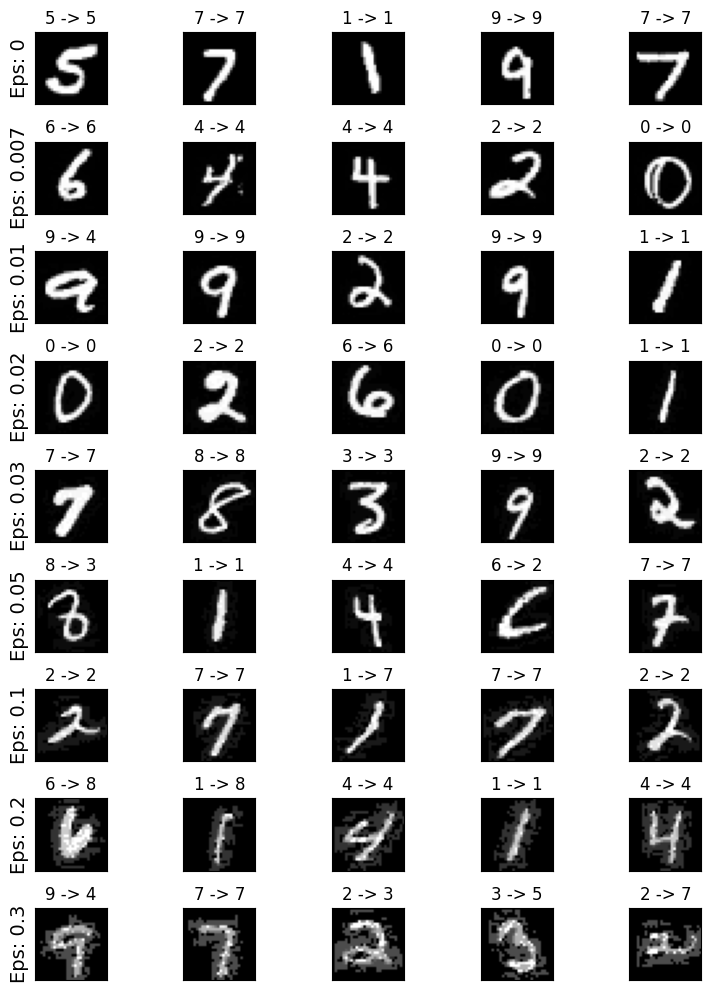

Epsilon: 0	Test Accuracy = 9763 / 10000 = 0.9763
Epsilon: 0.007	Test Accuracy = 9726 / 10000 = 0.9726
Epsilon: 0.01	Test Accuracy = 9695 / 10000 = 0.9695
Epsilon: 0.02	Test Accuracy = 9654 / 10000 = 0.9654
Epsilon: 0.03	Test Accuracy = 9586 / 10000 = 0.9586
Epsilon: 0.05	Test Accuracy = 9419 / 10000 = 0.9419
Epsilon: 0.1	Test Accuracy = 8598 / 10000 = 0.8598
Epsilon: 0.2	Test Accuracy = 5921 / 10000 = 0.5921
Epsilon: 0.3	Test Accuracy = 3660 / 10000 = 0.366


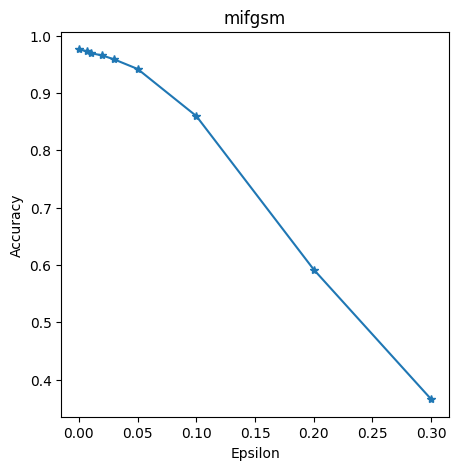

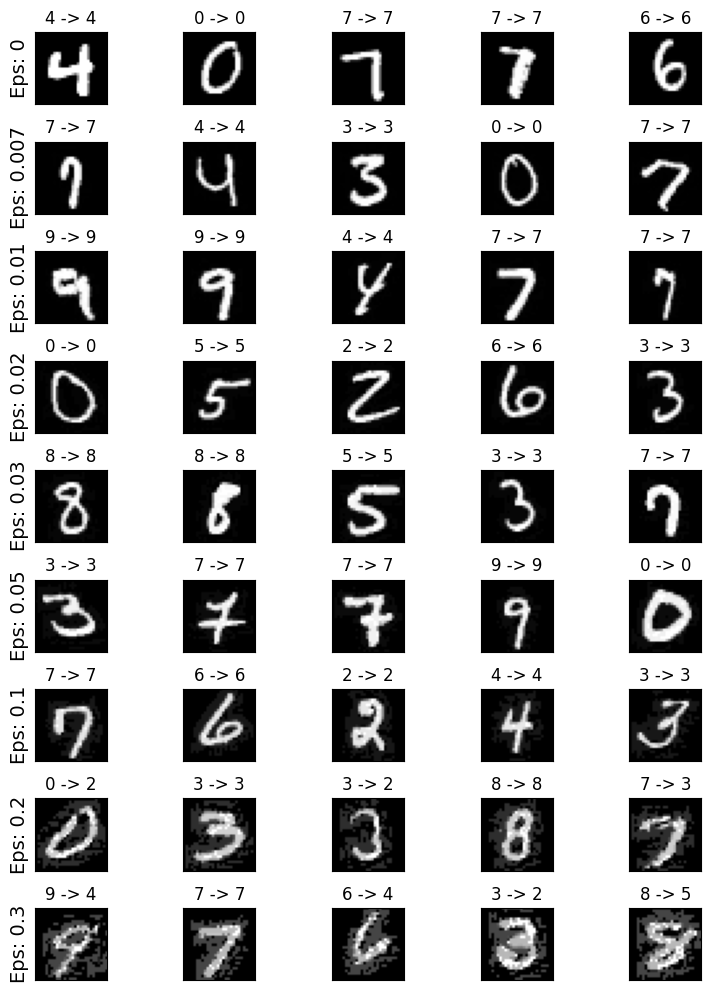

In [ ]:
epsilons = [0,0.007,0.01,0.02,0.03,0.05,0.1,0.2,0.3]
for attack in ("fgsm","ifgsm","mifgsm"):
  accuracies = []
  examples = []
  for eps in epsilons:
    acc, ex = test(model, device,test_loader,eps,attack)
    accuracies.append(acc)
    examples.append(ex)
  plt.figure(figsize=(5,5))
  plt.plot(epsilons, accuracies, "*-")
  plt.title(attack)
  plt.xlabel("Epsilon")
  plt.ylabel("Accuracy")
  plt.show()


  cnt = 0
  plt.figure(figsize=(8,10))
  for i in range(len(epsilons)):
    for j in range(len(examples[i])):
      cnt += 1
      plt.subplot(len(epsilons),len(examples[0]),cnt)
      plt.xticks([], [])
      plt.yticks([], [])
      if j == 0:
        plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
      orig,adv,ex = examples[i][j]
      plt.title("{} -> {}".format(orig, adv))
      plt.imshow(ex, cmap="gray")
  plt.tight_layout()
  plt.show()

Защита от атак

Создадим два класса НС

In [ ]:
class NetF(nn.Module):
  def __init__(self):
    super(NetF, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    return x

class NetF1(nn.Module):
  def __init__(self):
    super(NetF1, self).__init__()
    self.conv1 = nn.Conv2d(1, 16, 3, 1)
    self.conv2 = nn.Conv2d(16, 32, 3, 1)
    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(4608, 64)
    self.fc2 = nn.Linear(64, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    return x

Переопределим функцию обучения и тестирования

In [ ]:
def fit(model,device,optimizer,scheduler,criterion,train_loader,val_loader,Temp,epochs):
  data_loader = {'train':train_loader,'val':val_loader}
  print("Fitting the model...")
  train_loss,val_loss=[],[]
  for epoch in range(epochs):
    loss_per_epoch,val_loss_per_epoch=0,0
    for phase in ('train','val'):
      for i,data in enumerate(data_loader[phase]):
        input,label = data[0].to(device),data[1].to(device)
        output = model(input)
        output = F.log_softmax(output/Temp,dim=1)
        #calculating loss on the output
        loss = criterion(output,label)
        if phase == 'train':
          optimizer.zero_grad()
          #grad calc w.r.t Loss func
          loss.backward()
          #update weights
          optimizer.step()
          loss_per_epoch+=loss.item()
      else:
        val_loss_per_epoch+=loss.item()
    scheduler.step(val_loss_per_epoch/len(val_loader))
    print("Epoch: {} Loss: {} Val_Loss: {}".format(epoch+1,loss_per_epoch/len(train_loader),val_loss_per_epoch/len(val_loader)))
    train_loss.append(loss_per_epoch/len(train_loader))
    val_loss.append(val_loss_per_epoch/len(val_loader))
  return train_loss,val_loss
  def test(model,device,test_loader,epsilon,Temp,attack):
    correct=0
    adv_examples = []
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      data.requires_grad = True
      output = model(data)
      output = F.log_softmax(output/Temp,dim=1)
      init_pred = output.max(1, keepdim=True)[1]
      if init_pred.item() != target.item():
        continue
      loss = F.nll_loss(output, target)
      model.zero_grad()
      loss.backward()
      data_grad = data.grad.data
      if attack == "fgsm":
        perturbed_data = fgsm_attack(data,epsilon,data_grad)
      elif attack == "ifgsm":
        perturbed_data = ifgsm_attack(data,epsilon,data_grad)
      elif attack == "mifgsm":
        perturbed_data = mifgsm_attack(data,epsilon,data_grad)
      output = model(perturbed_data)
      final_pred = output.max(1, keepdim=True)[1]
      if final_pred.item() == target.item():
        correct += 1
        if (epsilon == 0) and (len(adv_examples) < 5):
          adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
          adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
          if len(adv_examples) < 5:
            adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
            adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
  final_acc = correct/float(len(test_loader))
  print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))
  return final_acc,adv_examples

Создадим функцию защиты методом дистилляции

In [ ]:
def defense(device,train_loader,val_loader,test_loader,epochs,Temp,epsilons):
  modelF = NetF().to(device)
  optimizerF = optim.Adam(modelF.parameters(),lr=0.0001, betas=(0.9, 0.999))
  schedulerF = optim.lr_scheduler.ReduceLROnPlateau(optimizerF, mode='min', factor=0.1, patience=3)
  modelF1 = NetF1().to(device)
  optimizerF1 = optim.Adam(modelF1.parameters(),lr=0.0001, betas=(0.9, 0.999))
  schedulerF1 = optim.lr_scheduler.ReduceLROnPlateau(optimizerF1, mode='min', factor=0.1, patience=3)
  criterion = nn.NLLLoss()
  lossF,val_lossF=fit(modelF,device,optimizerF,schedulerF,criterion,train_loader,val_loader,Temp,epochs)
  fig = plt.figure(figsize=(5,5))
  plt.plot(np.arange(1,epochs+1), lossF, "*-",label="Loss")
  plt.plot(np.arange(1,epochs+1), val_lossF,"o-",label="Val Loss")
  plt.title("Network F")
  plt.xlabel("Num of epochs")
  plt.legend()
  plt.show()
  #converting target labels to soft labels
  for data in train_loader:
    input, label = data[0].to(device),data[1].to(device)
    softlabel = F.log_softmax(modelF(input),dim=1)
    data[1] = softlabel
  lossF1,val_lossF1=fit(modelF1,device,optimizerF1,schedulerF1,criterion,train_loader,val_loader,Temp,epochs)
  fig = plt.figure(figsize=(5,5))
  plt.plot(np.arange(1,epochs+1), lossF1, "*-",label="Loss")
  plt.plot(np.arange(1,epochs+1), val_lossF1,"o-",label="Val Loss")
  plt.title("Network F'")
  plt.xlabel("Num of epochs")
  plt.legend()
  plt.show()
  model = NetF1().to(device)
  model.load_state_dict(modelF1.state_dict())
  for attack in ("fgsm","ifgsm","mifgsm"):
    accuracies = []
    examples = []
    for eps in epsilons:
      acc, ex = test(model,device,test_loader,eps,"fgsm")
      accuracies.append(acc)
      examples.append(ex)
  plt.figure(figsize=(5,5))
  plt.plot(epsilons, accuracies, "*-")
  plt.title(attack)
  plt.xlabel("Epsilon")
  plt.ylabel("Accuracy")
  plt.show()



  cnt = 0
  plt.figure(figsize=(8,10))
  for i in range(len(epsilons)):
    for j in range(len(examples[i])):
      cnt += 1
      plt.subplot(len(epsilons),len(examples[0]),cnt)
      plt.xticks([], [])
      plt.yticks([], [])
      if j == 0:
        plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
      orig,adv,ex = examples[i][j]
      plt.title("{} -> {}".format(orig, adv))
      plt.imshow(ex, cmap="gray")
  plt.tight_layout()
  plt.show()

Получим результаты оценки защищенных сетей

Fitting the model...
Epoch: 1 Loss: 0.5452941701858685 Val_Loss: 6.037708790972829e-06
Epoch: 2 Loss: 0.32425381627099736 Val_Loss: 9.949106127023697e-05
Epoch: 3 Loss: 0.23385002086981302 Val_Loss: 9.079241193830967e-06
Epoch: 4 Loss: 0.1702664084006976 Val_Loss: 4.3910506647080184e-07
Epoch: 5 Loss: 0.13932190553698148 Val_Loss: 1.3171765010611126e-08
Epoch: 6 Loss: 0.11892594072425135 Val_Loss: 3.120585170108825e-08
Epoch: 7 Loss: 0.10816406371179825 Val_Loss: 2.5707904994487762e-05
Epoch: 8 Loss: 0.1000463242246654 Val_Loss: 1.0828851535916328e-05
Epoch: 9 Loss: 0.09229341485548419 Val_Loss: 8.06882232427597e-07
Epoch: 10 Loss: 0.08371142824869483 Val_Loss: 7.650002837181091e-05


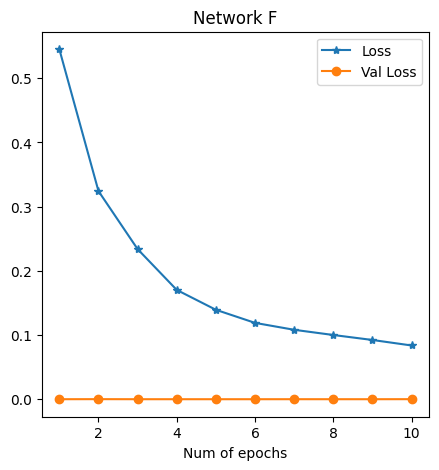

Fitting the model...
Epoch: 1 Loss: 0.7000928725314399 Val_Loss: 0.00021557913720607759
Epoch: 2 Loss: 0.4676942685559186 Val_Loss: 0.00010859122425317764
Epoch: 3 Loss: 0.40884532819504427 Val_Loss: 1.1391235457267613e-07
Epoch: 4 Loss: 0.35834496666243826 Val_Loss: 0.00018238469749921933
Epoch: 5 Loss: 0.3083399293145933 Val_Loss: 5.7299271691590546e-05
Epoch: 6 Loss: 0.26419955346445734 Val_Loss: 3.736803846550174e-08
Epoch: 7 Loss: 0.2332993528036344 Val_Loss: 5.95354390097782e-05
Epoch: 8 Loss: 0.2095177365646941 Val_Loss: 8.314711302518845e-05
Epoch: 9 Loss: 0.19635587823723236 Val_Loss: 7.661414864742256e-06
Epoch: 10 Loss: 0.1780492765141595 Val_Loss: 8.553688228124656e-06


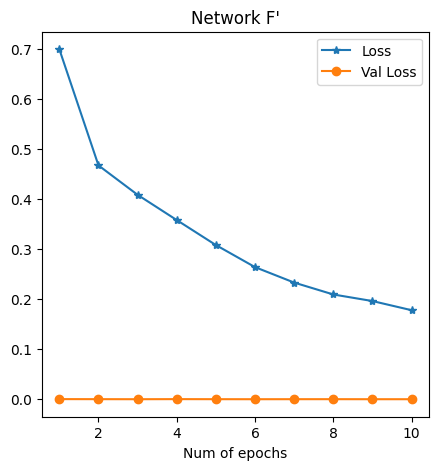

Epsilon: 0	Test Accuracy = 9218 / 10000 = 0.9218
Epsilon: 0.007	Test Accuracy = 9168 / 10000 = 0.9168
Epsilon: 0.01	Test Accuracy = 9170 / 10000 = 0.917
Epsilon: 0.02	Test Accuracy = 9086 / 10000 = 0.9086
Epsilon: 0.03	Test Accuracy = 8941 / 10000 = 0.8941
Epsilon: 0.05	Test Accuracy = 8649 / 10000 = 0.8649
Epsilon: 0.1	Test Accuracy = 7555 / 10000 = 0.7555
Epsilon: 0.2	Test Accuracy = 3770 / 10000 = 0.377
Epsilon: 0.3	Test Accuracy = 1488 / 10000 = 0.1488
Epsilon: 0	Test Accuracy = 9215 / 10000 = 0.9215
Epsilon: 0.007	Test Accuracy = 9150 / 10000 = 0.915
Epsilon: 0.01	Test Accuracy = 9125 / 10000 = 0.9125
Epsilon: 0.02	Test Accuracy = 9052 / 10000 = 0.9052
Epsilon: 0.03	Test Accuracy = 8928 / 10000 = 0.8928
Epsilon: 0.05	Test Accuracy = 8685 / 10000 = 0.8685
Epsilon: 0.1	Test Accuracy = 7649 / 10000 = 0.7649
Epsilon: 0.2	Test Accuracy = 3749 / 10000 = 0.3749
Epsilon: 0.3	Test Accuracy = 1508 / 10000 = 0.1508
Epsilon: 0	Test Accuracy = 9247 / 10000 = 0.9247
Epsilon: 0.007	Test Accuracy

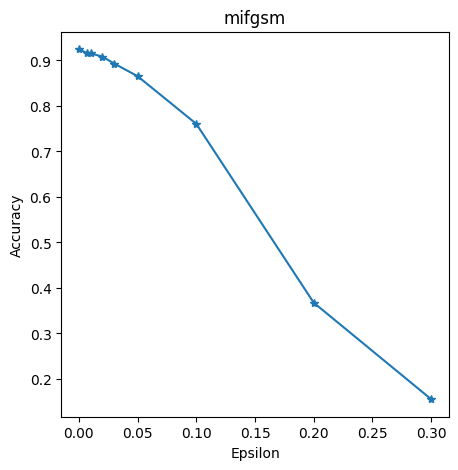

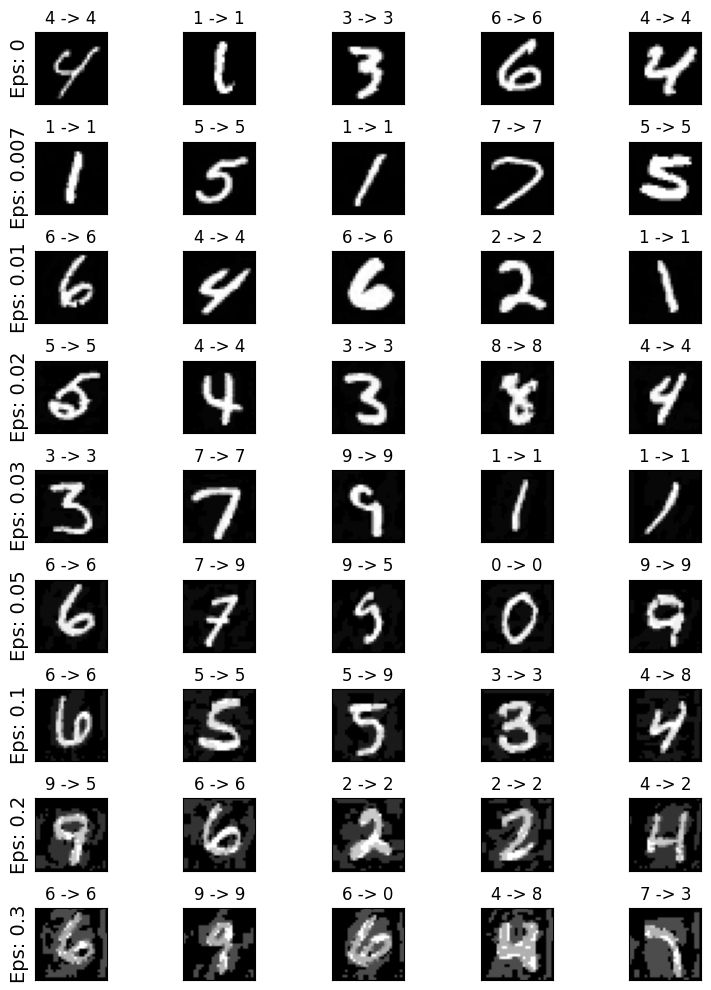

In [ ]:
Temp=100
epochs=10
epsilons=[0,0.007,0.01,0.02,0.03,0.05,0.1,0.2,0.3]
defense(device,train_loader,val_loader,test_loader,epochs,Temp,epsilons)

По полученным результатам можем сделать вывод, что точность была увеличена.